In [1]:
import scipy.io
import netCDF4
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, glob 
import imageio
from matplotlib import animation
import copy
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter #see https://scitools.org.uk/cartopy/docs/v0.15/examples/tick_labels.html
import certifi
import ssl
import math
ssl._create_default_https_context = ssl._create_unverified_context
from scipy import stats
from xgcm import Grid
import statsmodels.api as sm
import matplotlib.ticker as ticker
from matplotlib.axes._secondary_axes import SecondaryAxis
import xesmf as xe
import warnings
import os

In [27]:
f='/scratch/abf376/FAFMIP/ACCESS-OM2/FAF-heat/so_yr_ACCESS-OM2_FAF-heat_01-70.nc'
salt_heat=xr.open_dataset(f)['salt']
salt_heat=salt_heat.where(salt_heat !=9.969209968386869e+36) #get rid of weird values

f='/scratch/abf376/FAFMIP/ACCESS-OM2/FAF-control/so_yr_ACCESS-OM2_FAF-control_01-70.nc'
salt_control=xr.open_dataset(f)['salt']
salt_control=salt_control.where(salt_control !=9.969209968386869e+36) #get rid of weird values

f='/scratch/abf376/FAFMIP/ACCESS-OM2/FAF-water/so_yr_ACCESS-OM2_FAF-water_01-70.nc'
salt_water=xr.open_dataset(f)['salt']
salt_water=salt_water.where(salt_water !=9.969209968386869e+36) #get rid of weird values

In [12]:
import cmocean

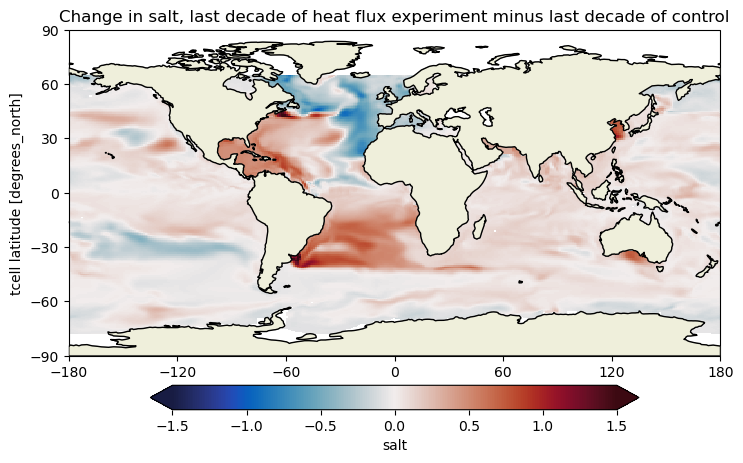

In [26]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},figsize=(10,8),dpi=100) #this is from cartopy https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html
p=(salt_heat[60:70,0,:,:].mean('time')-salt_control[60:70,0,:,:].mean('time')).where(salt_heat[0,0,:,:].yt_ocean<65).plot(cmap=cmocean.cm.balance,vmax=1.5,vmin=-1.5,cbar_kwargs={'shrink':0.75,'orientation':'horizontal','extend':'both','pad':0.05},ax=ax,alpha=1) #you have to set a colormap here because plotting xarray infers from the 
ax.coastlines(color='grey',lw=0.5)
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
plt.title('Change in salt, last decade of heat flux experiment minus last decade of control')
fig.tight_layout()

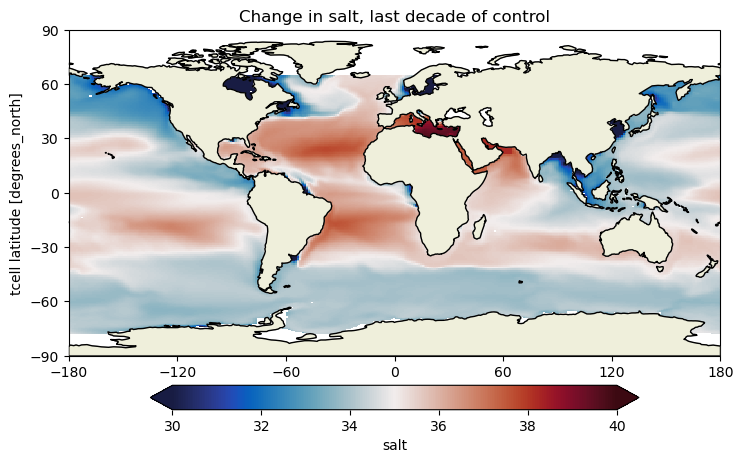

In [23]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},figsize=(10,8),dpi=100) #this is from cartopy https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html
p=(salt_control[60:70,0,:,:].mean('time')).where(salt_heat[0,0,:,:].yt_ocean<65).plot(cmap=cmocean.cm.balance,vmax=40,vmin=30,cbar_kwargs={'shrink':0.75,'orientation':'horizontal','extend':'both','pad':0.05},ax=ax,alpha=1) #you have to set a colormap here because plotting xarray infers from the 
ax.coastlines(color='grey',lw=0.5)
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
plt.title('Change in salt, last decade of control')
fig.tight_layout()

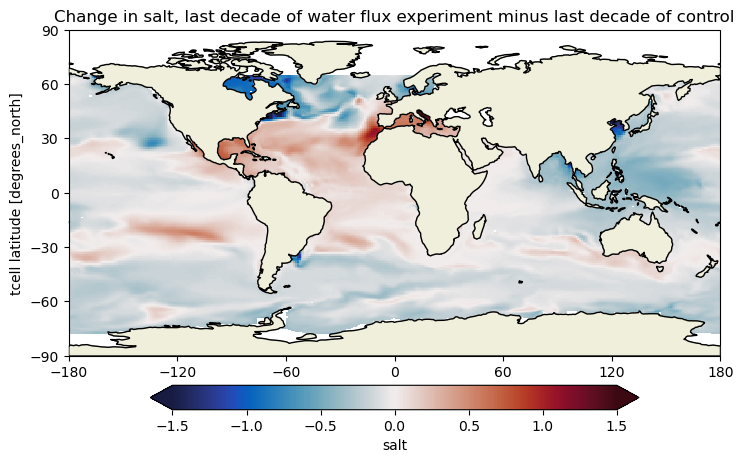

In [28]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},figsize=(10,8),dpi=100) #this is from cartopy https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html
p=(salt_water[60:70,0,:,:].mean('time')-salt_control[60:70,0,:,:].mean('time')).where(salt_heat[0,0,:,:].yt_ocean<65).plot(cmap=cmocean.cm.balance,vmax=1.5,vmin=-1.5,cbar_kwargs={'shrink':0.75,'orientation':'horizontal','extend':'both','pad':0.05},ax=ax,alpha=1) #you have to set a colormap here because plotting xarray infers from the 
ax.coastlines(color='grey',lw=0.5)
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
plt.title('Change in salt, last decade of water flux experiment minus last decade of control')
fig.tight_layout()

Now plot trends in IAP data

In [2]:
#Load in salinity data and take annual mean
mean_annual_sal=np.empty([50,180,360])
for j in np.linspace(1972,2021,50):
    j=int(j)
    surface_sal=np.empty([12,180,360])
    surface_sal[:]=np.nan
    for i in np.linspace(1,12,12):
        i=int(i)
        if i<10:
            f='/scratch/abf376/IAP_salinity_data/CZ16_1_2000m_salinity_year_'
            f+=str(j)
            f+='_month_0'
        else:
            f='/scratch/abf376/IAP_salinity_data/CZ16_1_2000m_salinity_year_'
            f+=str(j)
            f+='_month_'
        f+=str(i)
        f+='.nc'
        lat = xr.open_dataset(f)['lat']
        lon = xr.open_dataset(f)['lon']
        depth_std = xr.open_dataset(f)['depth_std']
        sal=xr.open_dataset(f)['salinity']
        sal=sal.where(sal<999)
        surface_sal[i-1,:,:]=sal[:,:,0]
    surface_sal=xr.DataArray(surface_sal,dims=["month","lat","lon"],coords=[np.linspace(1,12,12),lat,lon])
    surface_sal=surface_sal.mean('month')
    mean_annual_sal[j-1973,:,:]=surface_sal 
mean_annual_sal=xr.DataArray(mean_annual_sal,dims=["year","lat","lon"],coords=[np.linspace(1972,2021,50),lat,lon])

/state/partition1/job-27513759/ipykernel_3959747/3868705780.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


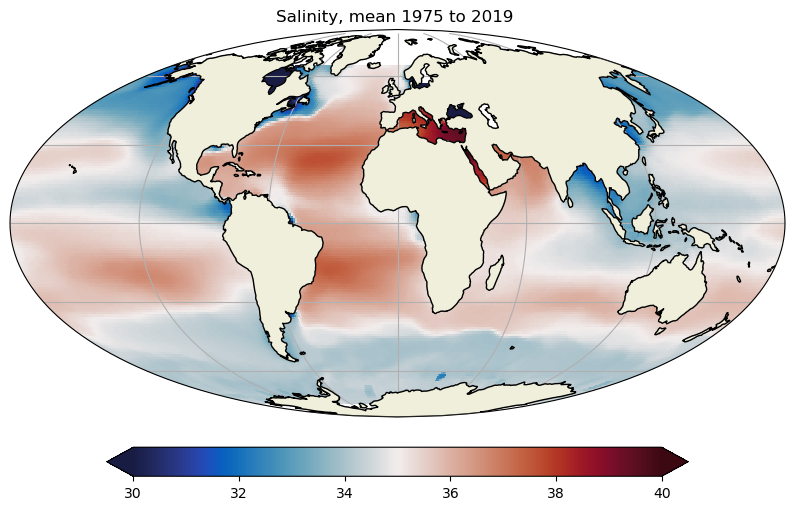

In [33]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.Mollweide()},figsize=(10,8),dpi=100) #this is from cartopy https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html
(mean_annual_sal[3:48,:,:].mean('year')).where(mean_annual_sal.lat<65).plot(transform=ccrs.PlateCarree(),cmap=cmocean.cm.balance,vmax=40,vmin=30,cbar_kwargs={'shrink':0.75,'orientation':'horizontal','extend':'both','pad':0.05},ax=ax,alpha=1) #you have to set a colormap here because plotting xarray infers from the 
ax.coastlines(color='grey',lw=0.5)
#ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.Mollweide())
#ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
#lon_formatter = LongitudeFormatter(zero_direction_label=True)
#lat_formatter = LatitudeFormatter()
ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False)
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
plt.title('Salinity, mean 1975 to 2019 ')
fig.tight_layout()

/state/partition1/job-27513759/ipykernel_3959747/1820038626.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


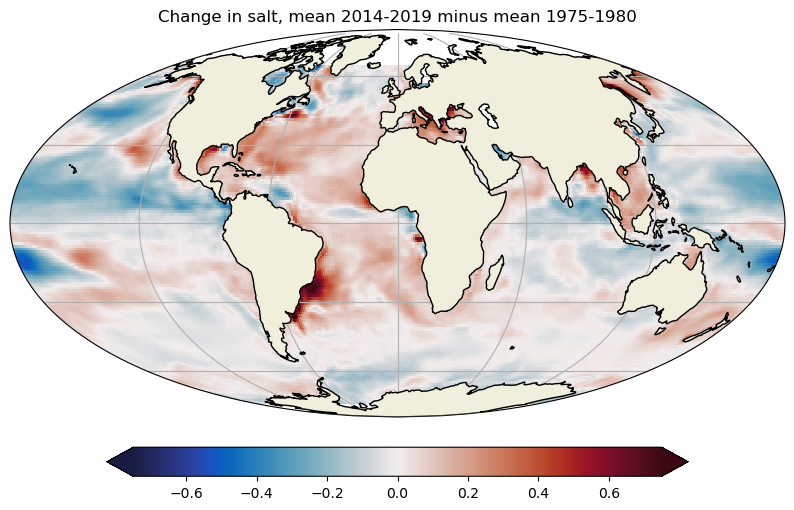

In [35]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.Mollweide()},figsize=(10,8),dpi=100) #this is from cartopy https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html
(mean_annual_sal[43:48,:,:].mean('year')-mean_annual_sal[3:8,:,:].mean('year')).where(mean_annual_sal.lat<65).plot(transform=ccrs.PlateCarree(),cmap=cmocean.cm.balance,vmax=0.75,vmin=-0.75,cbar_kwargs={'shrink':0.75,'orientation':'horizontal','extend':'both','pad':0.05},ax=ax,alpha=1) #you have to set a colormap here because plotting xarray infers from the 
ax.coastlines(color='grey',lw=0.5)
#ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.Mollweide())
#ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
#lon_formatter = LongitudeFormatter(zero_direction_label=True)
#lat_formatter = LatitudeFormatter()
ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False)
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
plt.title('Change in salt, mean 2014-2019 minus mean 1975-1980')
fig.tight_layout()

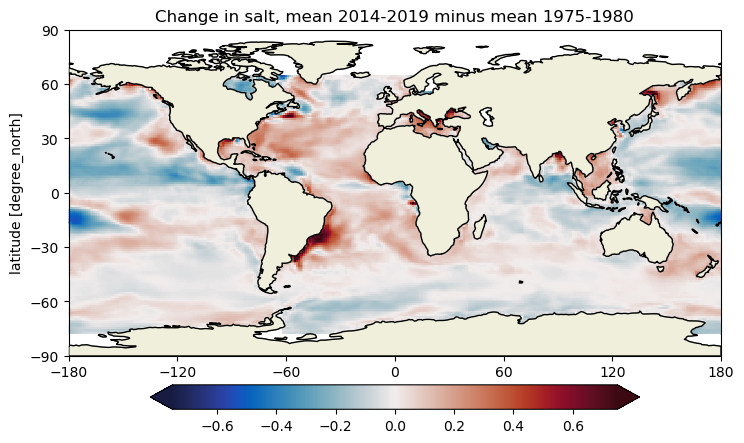

In [19]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},figsize=(10,8),dpi=100) #this is from cartopy https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html
p=(mean_annual_sal[43:48,:,:].mean('year')-mean_annual_sal[3:8,:,:].mean('year')).where(mean_annual_sal.lat<65).plot(cmap=cmocean.cm.balance,vmax=0.75,vmin=-0.75,cbar_kwargs={'shrink':0.75,'orientation':'horizontal','extend':'both','pad':0.05},ax=ax,alpha=1) #you have to set a colormap here because plotting xarray infers from the 
ax.coastlines(color='grey',lw=0.5)
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
plt.title('Change in salt, mean 2014-2019 minus mean 1975-1980')
fig.tight_layout()